# Pre-processing and analysis of the dataset

In [11]:
import pymongo
import os

import string
import regex as re
import textacy.preprocessing as tprep

import numpy as np
import pandas as pd

import fasttext
import spacy
from spacy.language import Language
from spacy import displacy

from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

## 1. Retrieving the data from the database

In [12]:
mg_host = os.environ.get("MONGO_HOST")
mg_username = os.environ.get("MONGO_USER")
mg_password = os.environ.get("MONGO_PW")
client = pymongo.MongoClient(f'mongodb://{mg_username}:{mg_password}@{mg_host}')

cvs = client.badtranslator.cvs

## 2. Creation and pre-processing of the dataset

In [13]:
def mongo_to_pandas(db_coll, chunksize = 100, no_id=True):

    # Size of chunks
    skips_variable = range(0, db_coll.count_documents({}), int(chunksize))
    
    if len(skips_variable)<=1:
        skips_variable = [0,len(skips_variable)]

    for i in range(0, len(skips_variable)):
        
        if (skips_variable.stop - i * skips_variable.step < skips_variable.step):
            df_aux =pd.DataFrame(list(db_coll.find()[skips_variable[i]:skips_variable.stop+1]))
        else:                    
            df_aux =pd.DataFrame(list(db_coll.find()[skips_variable[i]:skips_variable[i+1]]))

        if no_id:
            del df_aux['_id']

        if 'df' not in locals():
            df =  df_aux
        else:
            df = pd.concat([df, df_aux], ignore_index=True)

    return df

In [14]:
df = mongo_to_pandas(cvs)

In [15]:
print(df.count())

email      812
cv        1541
status    1541
name       729
dtype: int64


Are there colums with null values beside 'email' and 'name'? **No**

In [16]:
for col in df.columns:
    print(col, df[col].isnull().sum())

email 729
cv 0
status 0
name 812


Language detection, because we only want resumes in English!

In [17]:
pretrained_model = "lid.176.bin" 
# Size: 129MB  , Download: https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
model = fasttext.load_model(pretrained_model)
langs = []

for item in df['cv']:
    item = item.replace("\n"," ")
    lang = model.predict(item)[0]
    langs.append(str(lang)[11:13])

df['lang'] = langs

In [18]:
df.loc[~df['lang'].isin(['en', 'ca', 'uk'])].sample(10)

,email,cv,status,name,lang
875,NaN,Anna Rebecca Tellez \nEmail: tellezanna@gmail....,good,Anna Tellez,es
1281,NaN,Curriculum Vitae\nInformazioni personali\nNome...,good,o,it
971,NaN,DEBORAH L. HOWZE \nBARRIO VICENTE \nROCAFUERTE...,good,Deborah Howze,es
1033,NaN,Fionn MacKillop \nNationalité: Britannique \n6...,good,mackUK,fr
1343,NaN,"NICOLA HOLMES \nTraducteur du français, de les...",good,Nicola Holmes,fr
867,NaN,"WATKINSON, ANDREW B.A. HONS \nNacionalidad: Br...",good,y Watkinson,es
837,NaN,\t\r \t\r ALEXIS\t\r RHYNER\t\r \t\r \t\...,good,Alexis Rhyner,fr
1056,NaN,lagartijaverde: soluciones lingüísticas \nemai...,good,on Byron,es
991,NaN,FRIEDRICHSFELDER STR. 8 69123 HEIDELBERG TEL...,good,Dr. Kathleen Cross,de
1173,NaN,Curriculum Vitae \nKaren Chalmers \ninfo@kctra...,good,Karen Chalmers,es


*References*

@article{joulin2016bag,
  title={Bag of Tricks for Efficient Text Classification},
  author={Joulin, Armand and Grave, Edouard and Bojanowski, Piotr and Mikolov, Tomas},
  journal={arXiv preprint arXiv:1607.01759},
  year={2016}
}

We filter these records.

In [19]:
df_filtered = df.loc[df['lang'].isin(['en', 'ca', 'uk'])]

Shuffling of the dataset, because of the label bias of the original dataset.

In [20]:
df_filtered = df_filtered.sample(frac=1).reset_index(drop=True)

Removing the not needed columns

In [21]:
df_filtered.drop(["email"], axis=1, inplace=True)
df_filtered.drop(["name"], axis=1, inplace=True)
df_filtered.drop(["lang"], axis=1, inplace=True)

In [22]:
df_filtered.sample(5).T

,1420,422,804,1094,798
cv,Anders Beck \n Translation and content writin...,Resume\nName : Kathy Jack \nGender: Female\nNa...,To Whom It May Concern: \nRufino Pérez De La S...,CV \nPersonal information: \nName: Merna Jenif...,"Address: \n384 Larkin St \nMonterey, CA 93940 ..."
status,bad,bad,good,bad,good


## 3. Persistent copy of the dataframe

In [23]:
df_filtered.to_pickle("cvs_dataframe.pkl")

In [24]:
df_filtered = pd.read_pickle("cvs_dataframe.pkl")

## 4. Text normalization of column cv

### 4.1 Lowercasing of the cv column

In [25]:
df_filtered['cv'] = df_filtered['cv'].apply(lambda x: x.lower())

### 4.2 Contractions

Are there contractions. Check with "I'm".

In [26]:
contractions = df_filtered.loc[df_filtered['cv'].str.contains("I'm", case=False)]
print(contractions)

                                                     cv status
48    michael roberts\nmichael@vivtek.com\nhc 1 box ...   good
152   fluent in english and swedish  spoken and read...    bad
240    pesronal info \nname: allia mozo \ngender: fe...    bad
276   curriculum vitae \nemail: rankay@hotmail.com \...    bad
348   dk1307 københavn, denmark  catrinekarlsson@out...    bad
390   experienced chinesemandarin, japanese, english...    bad
443   sarah kate michel, fortis green rd, muswell hi...   good
483   a l i t t l e a b o u t m e :\nla cruz a medic...   good
570   yeal leon\naddress: 13 gur yehuda st, tel aviv...    bad
594   curriculum vitae\nmaria bozell\nfreelance tran...    bad
595   john lonergan \njohn lonergan \ntranslations f...   good
676   mary mcarthur \n1831 pacific avenue, suite 301...   good
1034  resume\nname :\namanda steive\ngender:\nfemale...    bad
1052  ian wang \n8year freelance englishchinese tran...    bad
1211  andré barreiros alves ribeiro\nf r e e l a n c...

Fixing contractions: We leave that to the Spacy pipeline for the time being

In [27]:
# import contractions
# df_filtered['cv'] = df_filtered['cv'].apply(lambda x: contractions.fix(x))

### 4.3 Special characters

Cleaning "pipeline"

In [28]:
def clean(text):
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r' {2,}', ' ', text) # We leave the line breaks for the time being
    return text.strip()

In [29]:
df_filtered['cv'] = df_filtered['cv'].apply(lambda x: clean(x))

### 4.4 Punctuation

Removing punctuation: Is this actually needed? 

In [30]:
# df['cv'] = df['cv'].apply(lambda x: ''.join([token for token in x if token not in string.punctuation]))

### 4.5 Textacy pipeline

Textacy pipeline.
We won't mask e-mail adresses and phone numbers, because they convey important information (fakes).

In [31]:
preproc = tprep.make_pipeline(
    tprep.normalize.hyphenated_words, # Removes hyphens at the end of lines
    tprep.normalize.whitespace, # Normalize and strip leading white spaces
    tprep.normalize.quotation_marks, # Normalizes quotation marks
    tprep.normalize.unicode, # Normalizes accented characters for subsequent removal
    tprep.remove.accents # Removes accents
)

In [32]:
df_filtered['cv'] = df_filtered['cv'].apply(lambda x: preproc(x))

## 5. Spacy pipeline preconfiguration

We remove the parser component from the pipeline, because it has problems dealing with the CR/LF of the converted pdfs.

In [33]:
nlp = spacy.load('en_core_web_md', exclude=["parser"])
nlp.enable_pipe("senter")

In [34]:
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x1ebfde29280>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x1ebfdca7f40>),
 ('senter', <spacy.pipeline.senter.SentenceRecognizer at 0x1ebfdca7ee0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x1ebff13a380>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x1ebff14ff80>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x1ebfdb63970>)]

## 6. Processing with Spacy

### 6.1 Removal of stop words

In [35]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [36]:
df_filtered['no_stopwords'] = df_filtered['cv'].apply(
    lambda x: " ".join([token.text for token in nlp.tokenizer(x) if not token.is_stop]))

### 6.2 Tokenization

In [37]:
df_filtered['tokens'] = df_filtered['no_stopwords'].apply(lambda x: [t.text for t in nlp.tokenizer(x) \
if ((len(t.text) > 2) & (re.search(r'^\n\s{2,}$', t.text) is None))])
# len = 2 is an arbitrary setting that leaves special characters and line breaks out

## 7. Analysis

### 7.1 Number of fake vs. legitimate resumes

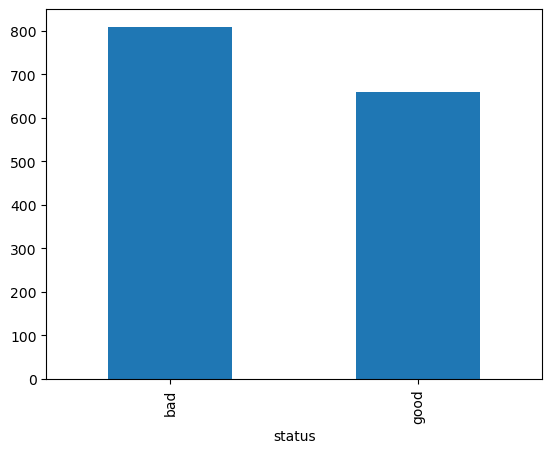

In [38]:
df_filtered.groupby(['status'])['cv'].count().plot(kind="bar")
plt.show()

### 7.2 Word cloud of legitimate resumes

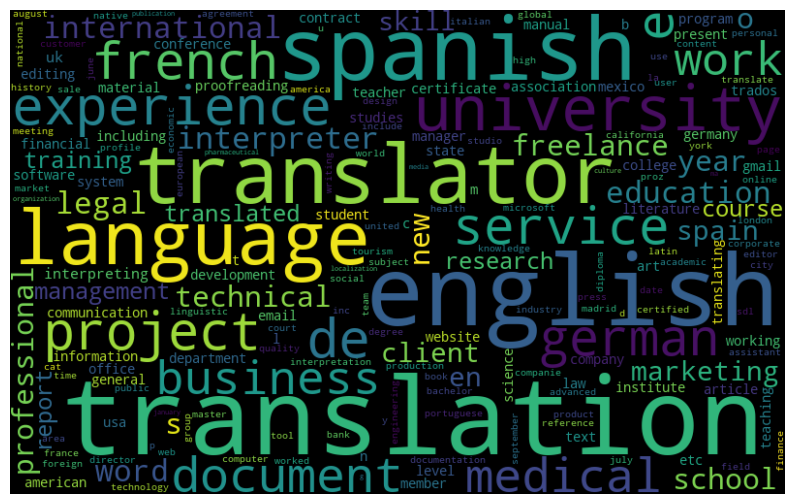

In [39]:
fake_cvs = df_filtered[df_filtered["status"] == "good"]
all_words = ' '.join([text for text in fake_cvs.no_stopwords])
wordcloud = WordCloud(width= 800, height= 500, max_font_size = 110, collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 7.3 Word cloud of the fake resumes

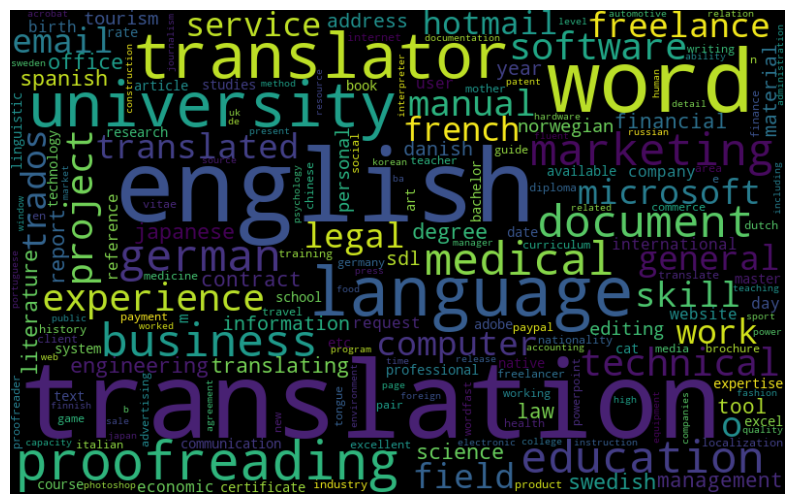

In [41]:
fake_cvs = df_filtered[df_filtered["status"] == "bad"]
all_words = ' '.join([text for text in fake_cvs.no_stopwords])
wordcloud = WordCloud(width= 800, height= 500, max_font_size = 110, collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Both work clouds look alike. Let's obtain the actual word frequencies of both subsets, "good" (legitimate) and "bad" (fake): 

### 7.4 Word frequency

#### 7.4.1 Word frequency in legitimate CVs

In [42]:
from collections import Counter

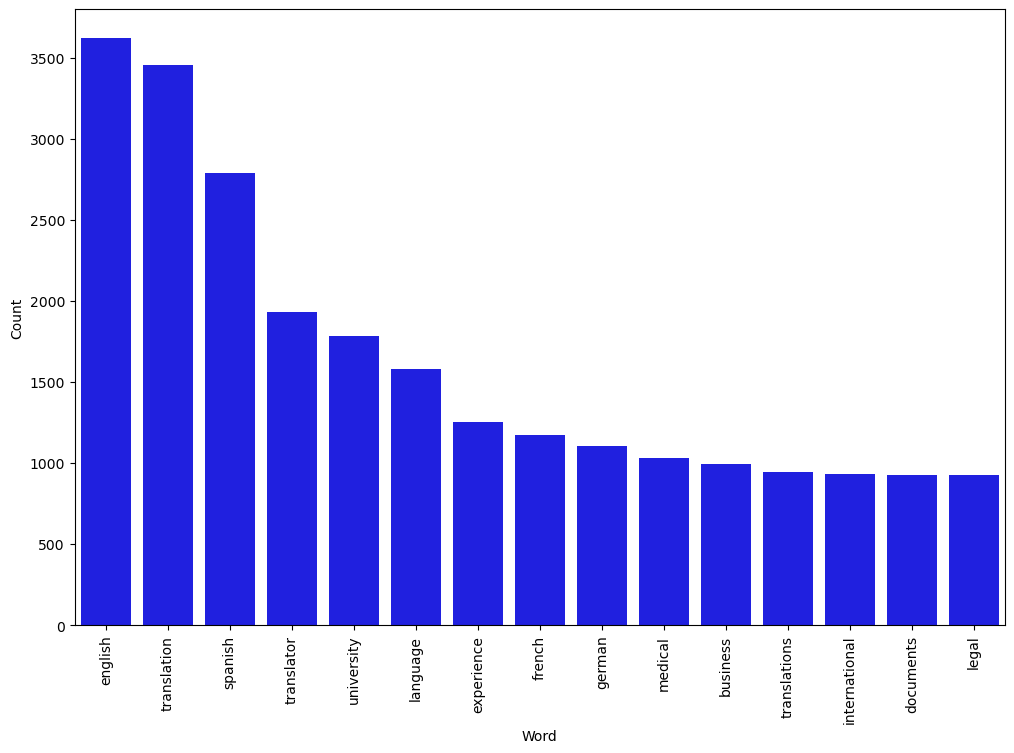

In [43]:
# tokens_good = [word for record in df_filtered[df_filtered["status"] == "good"]['tokens'].to_list() for word in record]
counter = Counter()
df_filtered[df_filtered["status"] == "good"]['tokens'].map(counter.update)
df_freq_good = pd.DataFrame.from_dict(counter, orient='index', columns=['Frequency'])
df_freq_good.index.name = 'Word'
df_freq_good_top15 = df_freq_good.nlargest(columns = "Frequency", n = 15)

plt.figure(figsize=(12,8))
ax = sns.barplot(data = df_freq_good_top15, x = df_freq_good_top15.index, y = "Frequency", color = 'blue')
ax.set(ylabel = "Count")
plt.xticks(rotation='vertical')
plt.show()

#### 7.4.2 Word frequency in fake CVs

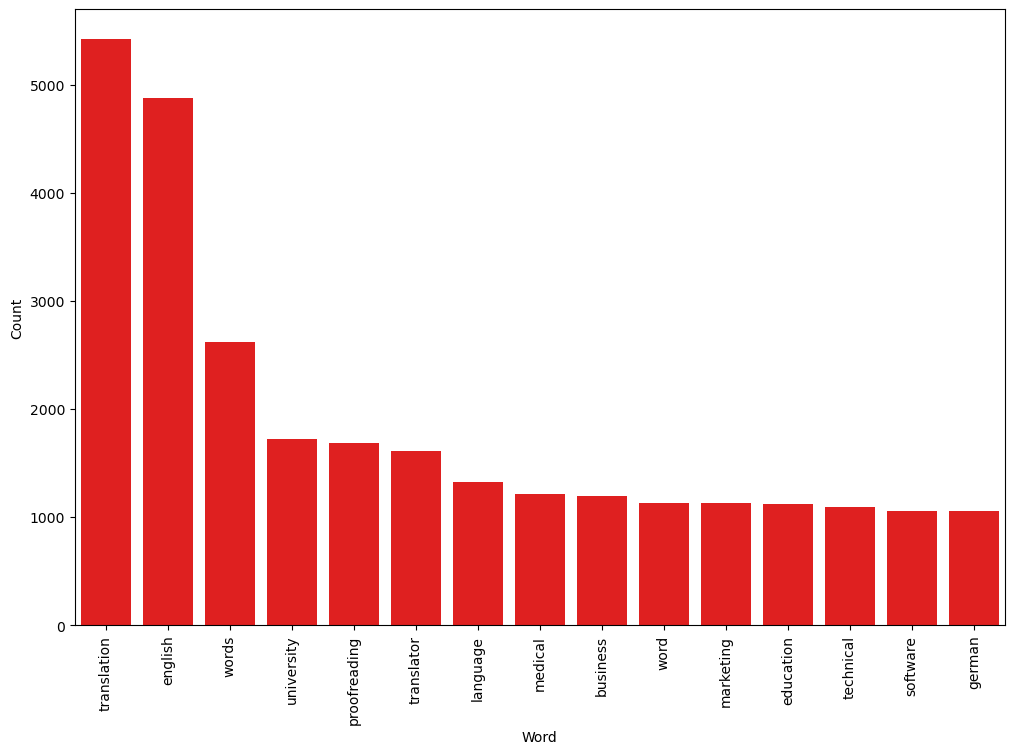

In [44]:
# tokens_bad = [word for record in df_filtered[df_filtered["status"] == "bad"]['tokens'].to_list() for word in record]
counter = Counter()
df_filtered[df_filtered["status"] == "bad"]['tokens'].map(counter.update)
df_freq_bad = pd.DataFrame.from_dict(counter, orient='index', columns=['Frequency'])
df_freq_bad.index.name = 'Word'
df_freq_bad_top15 = df_freq_bad.nlargest(columns = "Frequency", n = 15)

plt.figure(figsize=(12,8))
ax = sns.barplot(data = df_freq_bad_top15, x = df_freq_bad_top15.index, y = "Frequency", color = 'red')
ax.set(ylabel = "Count")
plt.xticks(rotation='vertical')
plt.show()

Unfortunately we can't appreciate any special traits in the "bad" subset. The most frequent words are obvious for the analyzed domain, "Translators".

We can resort to the IDF (Inverse Document Frequency), that expresses how "unusual" a term is in a corpus.


### 7.5 Inverse Document Frequency calculation (IDF) and TF-IDF scores

We first calculate the word frequency of the complete datase:

In [45]:
counter = Counter()
df_filtered['tokens'].map(counter.update)
df_frequency = pd.DataFrame.from_dict(counter, orient='index', columns=['Frequency'])
df_frequency.index.name = 'Word'

In [46]:
counter = Counter()
min_df = 2

def update(tokens):
    counter.update(set(tokens))

df_filtered['tokens'].map(update)

df_idf = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
df_idf = df_idf.query('df >= @min_df')
df_idf['idf'] = np.log(len(df_filtered)/df_idf['df']) + 0.1
df_idf.index.name = 'Word'

In [47]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    wc = WordCloud(width=1200, height=600, background_color= "black", colormap="Paired", \
    max_font_size=150, max_words=max_words)

    # convert DataFrame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq
    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() if token not in stopwords}

    wc.generate_from_frequencies(counter)
    plt.title(title)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

#### 7.5.1 IDF calculation and word cloud according to the TF-IDF scores for the subset of legitimate CVs

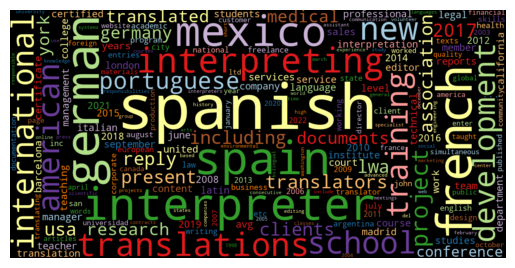

In [48]:
df_idf['tfidf'] = df_freq_good['Frequency'] * df_idf['idf']
wordcloud(df_idf['tfidf'])

#### 7.5.2 IDF calculation and word cloud according to the TF-IDF scores for the subset of fake CVs

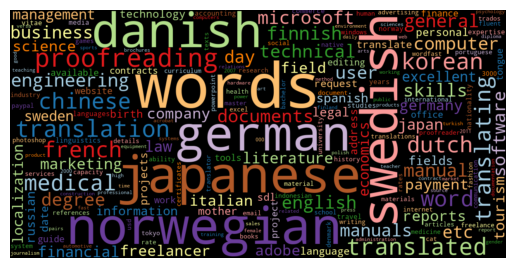

In [49]:
df_idf['tfidf'] = df_freq_bad['Frequency'] * df_idf['idf']
wordcloud(df_idf['tfidf'])

**We are into something!** The words that stand out after the IDF weighting are quite different in the "legitimate" subset compared to the "fake" subset. In the latter one we find words like *Japanese*, *Danish*, *Swedish*, *Norwegian*, and *Chinese*, that do not match the intended language combinations of the dataset, which are *German* <> *English*, *Spanish* <> *English*, and *French* <> *English*.

## 8. Backup of the normalized dataframe

In [50]:
df_filtered.to_pickle("cvs_dataframe_normalized.pkl")